In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import wandb
import tempfile
import os
from models.normalizing_flow import HierarchicalNormalizingFlowSB
import numpy as np
import torch
import matplotlib.pyplot as plt
from torch import nn


In [4]:
from train_flow_sb import unflatten, object_from_config

In [5]:
api = wandb.Api()

In [6]:
run = api.run('druhe/gw-src/12kl8jsy')

In [7]:
config = unflatten(run.config)

In [8]:
dataset = object_from_config(config, key='dataset')(**config['dataset'])

In [9]:
sb_weight = config['model']['sb_weight']

In [10]:
flows = object_from_config(config, key='flow')(**config['flow'])

In [11]:
checkpoints = [f for f in run.files() if f.name.endswith('.ckpt')]

In [12]:
tempdir = tempfile.TemporaryDirectory()

In [13]:
ckpt = checkpoints[0]

In [14]:
ckpt_path = ckpt.download(root=tempdir.name, replace=True)

In [15]:
model = HierarchicalNormalizingFlowSB.load_from_checkpoint(ckpt_path.name, dataset=dataset, sb_weight=sb_weight, flows=flows)

INFO:torch.distributed.nn.jit.instantiator:Created a temporary directory at /var/folders/d3/x840qlg17x1f92cnsrkq62fw0000gn/T/tmprlhllb7t
INFO:torch.distributed.nn.jit.instantiator:Writing /var/folders/d3/x840qlg17x1f92cnsrkq62fw0000gn/T/tmprlhllb7t/_remote_module_non_sriptable.py


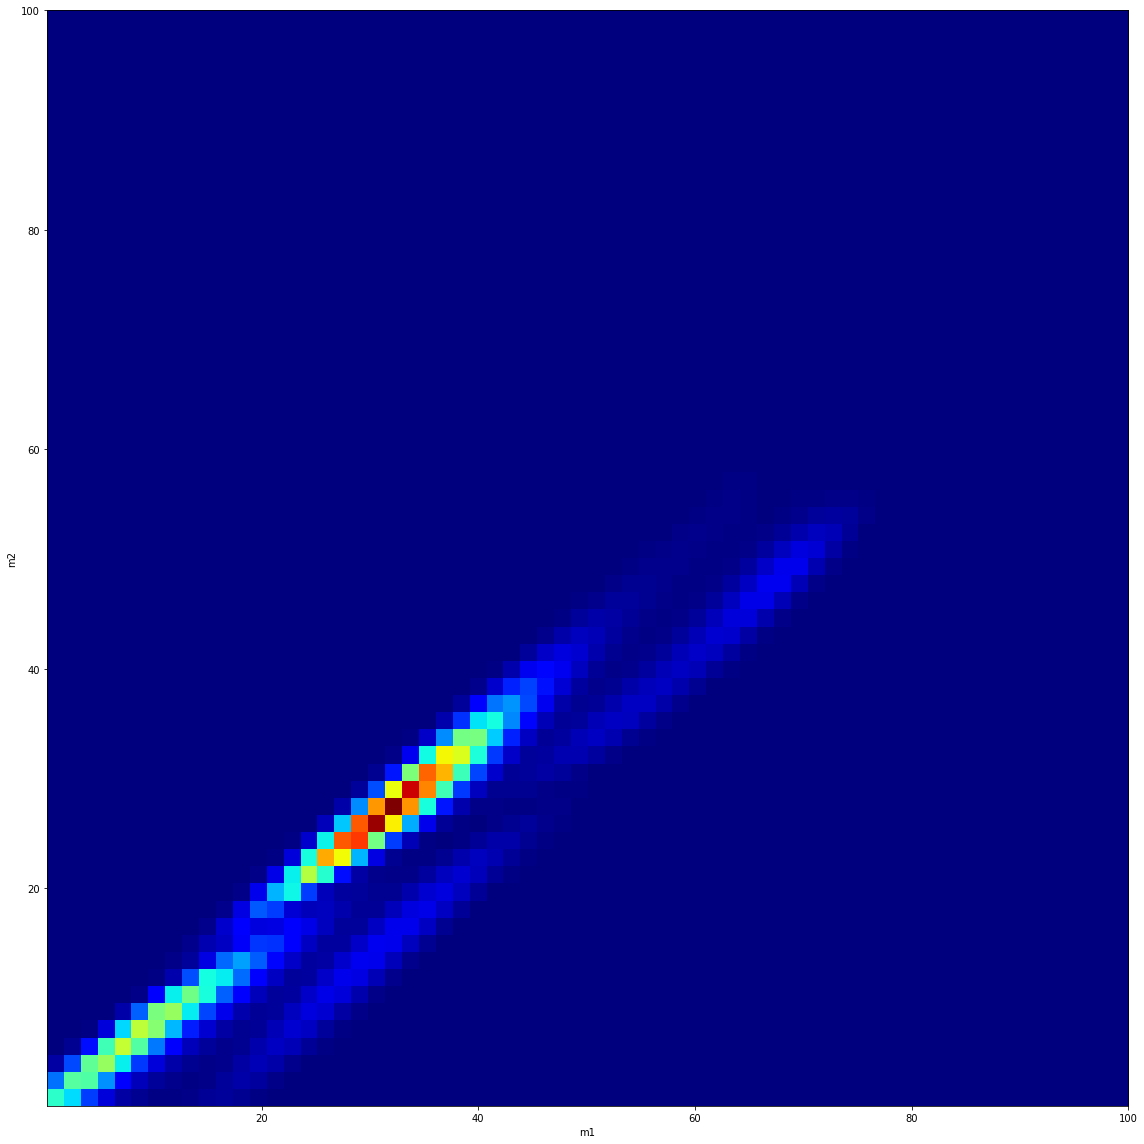

In [16]:
with torch.no_grad():
    axes_names = []
    axes = []

    for n, ax in dataset.grid.items():
        axes_names.append(n)
        axes.append(ax)

    m1, m2, z = np.stack(np.meshgrid(*axes, indexing="xy")).reshape(3, -1)

    if dataset.has_normalization:
        raise NotImplementedError
        x, y = dataset.normalize_forward(x, y)

    resolutions = [len(ax) for ax in axes]

    input = np.stack([m1, m2, z], axis=-1)
    input = torch.from_numpy(input).float()
    prob = model.log_prob(input).exp().view(*resolutions)

    pm1m2 = prob.sum(-1)

    fig = plt.figure(figsize=(16, 16), facecolor="white")
    plt.imshow(
        pm1m2,
        cmap="jet",
        origin="lower",
        extent=(
            axes[0][0],
            axes[0][-1],
            axes[1][0],
            axes[1][-1],
        ),  # origin='lower' changes the order
        aspect="auto",
    )

    plt.xlabel(axes_names[0])  # origin='lower' changes the order
    plt.ylabel(axes_names[1])
    plt.tight_layout()



In [17]:
probs = [model.log_prob(input).exp().view(*resolutions) for _ in range(128)]


In [19]:
probs = torch.stack(probs)

In [21]:
m1 = probs.sum(dim=(2, 3))

In [40]:
m1 = m1.detach().numpy()

In [43]:
m1_mu = np.median(m1, axis=0)
m1_005 = np.percentile(m1, 5, axis=0)
m1_095 = np.percentile(m1, 95, axis=0)

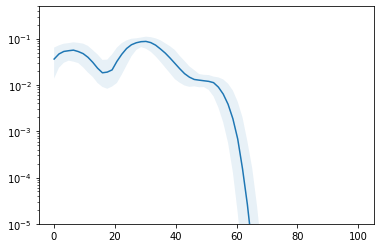

In [46]:
with torch.no_grad():
    plt.xlabel(axes_names[0])  # origin='lower' changes the order
    plt.ylabel(axes_names[1])
    plt.tight_layout()
    plt.close()
    plt.plot(axes[0], m1_mu)
    plt.fill_between(axes[0], m1_005, m1_095, alpha=0.1)
    plt.yscale('log')
    plt.ylim((1e-5, 0.5))
    plt.show()

